# Autoencoder 
This was taken from https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import tensorflow as tf
from transform_LC import transform_ztf_pickle

In [2]:
# set max number of cores
max_cores = 10

tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(intra_op_parallelism_threads=max_cores, 
                                                                                            inter_op_parallelism_threads=max_cores)))

## Pre-processing

In [14]:
# transform ZTF data
data, failed_train = transform_ztf_pickle(data_dir='data/lightcurves/zr400/', output_fname=False)

In [15]:
failed_train

['758204100014693.json', '.ipynb_checkpoints']

In [16]:
data.shape

(999, 400, 3)

In [22]:
train_data = data.copy()[:500]
test_data = data.copy()[500:]

In [28]:
# Shapes of training set
print("Training set (light curves) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (light curves) shape: {shape}".format(shape=test_data.shape))

Training set (light curves) shape: (500, 400, 3)
Test set (light curves) shape: (499, 400, 3)


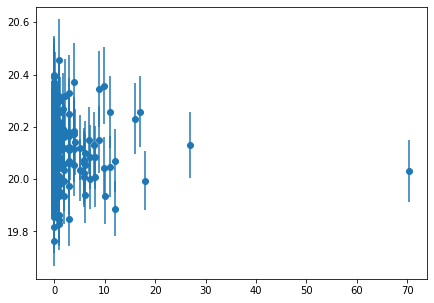

In [43]:
indx = np.random.choice(np.arange(0, train_data.shape[0]))

plt.figure(figsize=[7,5])

# Display the first image in training data
plt.errorbar(train_data[indx][:,0], train_data[indx][:,1], yerr=train_data[indx][:,2], fmt='o')
plt.show()

### Warning
The tutorial says that data should be normalized.
In our case this would loose meaning so it is not done here.

## Autoencoder

In [44]:
batch_size = 128
epochs = 5
inChannel = 1
x, y = 400, 3
input_img = Input(shape = (x, y, inChannel))

In [50]:
train_data = train_data.reshape(500,400,3,1)
test_data = test_data.reshape(499, 400, 3, 1)

In [56]:
28*28/32

24.5

In [57]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #400 x 3 x 32
    pool1 = MaxPooling2D(pool_size=(2, 1))(conv1) #200 x 3 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #200 x 3 x 64
    pool2 = MaxPooling2D(pool_size=(2, 1))(conv2) #100 x 3 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #100 x 3 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #100 x 3 x 128
    up1 = UpSampling2D((2,1))(conv4) # 200 x 3 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 200 x 3 x 64
    up2 = UpSampling2D((2,1))(conv5) # 400 x 3 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 400 x 3 x 1
    return decoded

In [58]:
autoencoder = Model(input_img, autoencoder(input_img))

In [59]:
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [60]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 3, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 400, 3, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 200, 3, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 3, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 3, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 3, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 3, 128)       147584

In [64]:
from sklearn.model_selection import train_test_split

# not sure why this is necessary
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

# train the model
autoencoder_train = autoencoder.fit(train_X, train_ground, 
                                   batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/5
4/4 [==============================] - 1s 317ms/step - loss: 138.1709 - val_loss: 134.6828
Epoch 2/5
4/4 [==============================] - 1s 270ms/step - loss: 136.0887 - val_loss: 134.6146
Epoch 3/5
4/4 [==============================] - 1s 307ms/step - loss: 136.0785 - val_loss: 134.6850
Epoch 4/5
4/4 [==============================] - 1s 301ms/step - loss: 136.1069 - val_loss: 134.6847
Epoch 5/5
4/4 [==============================] - 1s 294ms/step - loss: 136.1072 - val_loss: 134.6824


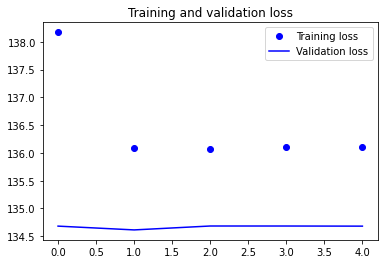

In [65]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Prediction on test data

In [72]:
pred_train = autoencoder.predict(train_data)

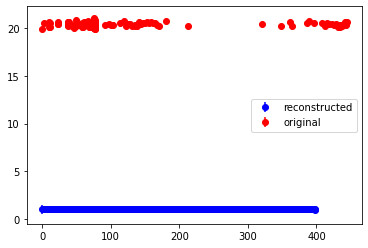

In [82]:
indx = np.random.choice(np.arange(0, pred_train.shape[0]))

x0 = 0

x = [x0]
y = [pred_train[indx][0][1][0]]
yerr = [pred_train[indx][0][2][0]]

xtrain0 = 0
xtrain = [xtrain0]
ytrain = [train_data[indx][0][1][0]]
yerrtrain = [train_data[indx][0][2][0]]

for i in range(1, pred_train.shape[1]):    
    # fix time axis for MJD
    x0 = x0 + pred_train[indx][i][0][0]
    x.append(x0)
    y.append(pred_train[indx][i][1][0])
    yerr.append(pred_train[indx][i][2][0])
    
    xtrain0 = xtrain0 + train_data[indx][i][0][0]
    xtrain.append(xtrain0)
    ytrain.append(train_data[indx][i][1][0])
    yerrtrain.append(train_data[indx][i][2][0])

plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt='o', color='b', label='reconstructed')
plt.errorbar(xtrain, ytrain, yerr=yerrtrain, fmt='o', color='r', label='original')
plt.legend()
plt.show()
